In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sn
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from yellowbrick.model_selection import ValidationCurve #pip install yellowbrick before running this command
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
import scikitplot as skplt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cluster import KMeans
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_csv("C:/Users/adity/Downloads/ML/training_data.csv", na_values=['?'])
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,N
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,N
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,N
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,N
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,N


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81414 entries, 0 to 81413
Data columns (total 50 columns):
encounter_id                81414 non-null int64
patient_nbr                 81414 non-null int64
race                        79601 non-null object
gender                      81414 non-null object
age                         81414 non-null object
weight                      2570 non-null object
admission_type_id           81414 non-null int64
discharge_disposition_id    81414 non-null int64
admission_source_id         81414 non-null int64
time_in_hospital            81414 non-null int64
payer_code                  49183 non-null object
medical_specialty           41479 non-null object
num_lab_procedures          81414 non-null int64
num_procedures              81414 non-null int64
num_medications             81414 non-null int64
number_outpatient           81414 non-null int64
number_emergency            81414 non-null int64
number_inpatient            81414 non-null int64
diag

In [3]:
percentage_missing = (data.isnull().sum()*100)/(len(data))
print(percentage_missing)

encounter_id                 0.000000
patient_nbr                  0.000000
race                         2.226890
gender                       0.000000
age                          0.000000
weight                      96.843295
admission_type_id            0.000000
discharge_disposition_id     0.000000
admission_source_id          0.000000
time_in_hospital             0.000000
payer_code                  39.589014
medical_specialty           49.051760
num_lab_procedures           0.000000
num_procedures               0.000000
num_medications              0.000000
number_outpatient            0.000000
number_emergency             0.000000
number_inpatient             0.000000
diag_1                       0.022109
diag_2                       0.353748
diag_3                       1.381826
number_diagnoses             0.000000
max_glu_serum                0.000000
A1Cresult                    0.000000
metformin                    0.000000
repaglinide                  0.000000
nateglinide 

### Because of high number of missing values, columns weight, payer_code and medical_specialty are removed. Since there are adequate number of observations in the dataset, the other missing values need not be imputed and those observations can be deleted. 

In [4]:
data.drop(['weight','payer_code','medical_specialty','encounter_id','patient_nbr'], axis=1, inplace=True)

In [5]:
#Deleting observations with missing values in Race and diag_1
#Removing the 2 values of gender with data unknown/invalid
data.dropna(subset = ["race","diag_1","diag_2","diag_3"], inplace=True)
data = data[data["gender"] != "Unknown/Invalid"]
data.reset_index(drop=True, inplace=True)

### It has been identified by reading in a research paper that the values that start with 250 are indicators of diabetes

In [6]:
data['readmitted'] = [0 if value == 'N' else 1 for value in data['readmitted']]
data['diag_1'] = data['diag_1'].astype(str)
data['diag_2'] = data['diag_2'].astype(str)
data['diag_3'] = data['diag_3'].astype(str)
data['diag_1'] = [1 if val.startswith('250') else 0 for val in data['diag_1']]
data['diag_2'] = [1 if val.startswith('250') else 0 for val in data['diag_2']]
data['diag_3'] = [1 if val.startswith('250') else 0 for val in data['diag_3']]

In [7]:
data.to_csv('diabetes.csv')

### It is expected that young people are much less prone to diabetes and the data also indicates that most people are within the age groups 60-80. So it made sense to recategorize age groups.

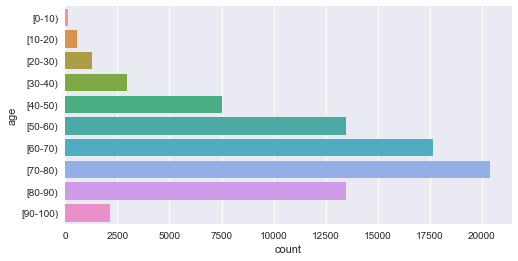

In [7]:
sn.set_style('darkgrid')
fig=plt.figure(figsize=(8,4))
ax=sn.countplot(y="age",data=data)

plt.show()

In [8]:
data['age'] = ['[0-40)' if val in ['[0-10)', '[10-20)', '[20-30)', '[30-40)'] else ('[40-70)' if val in ['[40-50)',  '[50-60)', '[60-70)'] 
               else '[70-100)') for val in data['age']]

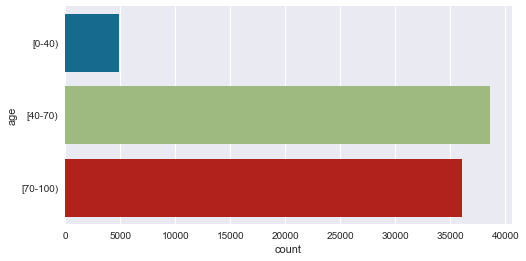

In [9]:
sn.set_style('darkgrid')
fig=plt.figure(figsize=(8,4))
ax=sn.countplot(y="age",data=data)

plt.show()

In [9]:
discharge_types = ['Discharged_to_home','Discharged/transferred_to_another_short_term_hospital','Discharged/transferred_to_SNF',
                   'Discharged/transferred_to_ICF','Discharged/transferred_to_another_type_of_inpatient_care_institution',
                   'Discharged/transferred_to_home_with_home_health_service','Left_AMA',
                   'Discharged/transferred_to_home_under_care_of_Home_IV_provider','Admitted_as_an_inpatient_to_this_hospital',
                   'Neonate_discharged_to_another_hospital_for_neonatal_aftercare','Expired',
                   'Still_patient_or_expected_to_return_for_outpatient_services','Hospice/home','Hospice/medical_facility',
                   'Discharged/transferred_within_this_institution_to_Medicare_approved_swing_bed',
                   'Discharged/transferred/referred_another_institution_for_outpatient_services',
                   'Discharged/transferred/referred_to_this_institution_for_outpatient_services','NULL','Expired_at_home',
                   'Expired_in_a_medical_facility','Expired_place_unknown',
                   'Discharged/transferred_to_another_rehab_fac_including_rehab_units_of_a_hospital',
                   'Discharged/transferred_to_a_long_term_care_hospital',
                   'Discharged/transferred_to_a_nursing_facility_certified_under_Medicaid_but_not_certified_under_Medicare',
                   'Not_Mapped','Unknown/Invalid',
                   'Discharged/transferred_to_another_Type_of_Health_Care_Institution_not_Defined_Elsewhere',
                   'Discharged/transferred_to_a_federal_health_care_facility',
                   'Discharged/transferred/referred_to_a_psychiatric_hospital_of_psychiatric_distinct_part_unit_of_a_hospital',
                   'Discharged/transferred_to_a_Critical_Access_Hospital']

data.discharge_disposition_id.replace(list(range(1,len(discharge_types)+1)),discharge_types, inplace=True)
data.discharge_disposition_id.head()

0    Discharged_to_home
1    Discharged_to_home
2    Discharged_to_home
3    Discharged_to_home
4    Discharged_to_home
Name: discharge_disposition_id, dtype: object

In [10]:
admission_sources = ['Physician_Referral','Clinic_Referral','HMO_Referral','Transfer_from_a_hospital',
                     'Transfer_from_a_Skilled_Nursing_Facility_(SNF)','Transfer_from_another_health_care_facility',
                     'Emergency_Room','Court/Law_Enforcement','Not_Available','Transfer_from_critial_access_hospital',
                     'Normal_Delivery','Premature_Delivery','Sick_Baby','Extramural_Birth','Not_Available','NULL',
                     'Transfer_From_Another_Home_Health_Agency','Readmission_to_Same_Home_Health_Agency','Not_Mapped',
                     'Unknown/Invalid','Transfer_from_hospital_inpt/same_fac_reslt_in_a_sep_claim','Born_inside_this_hospital',
                     'Born_outside_this_hospital','Transfer_from_Ambulatory_Surgery_Center','Transfer_from_Hospice']

data.admission_source_id.replace(list(range(1,len(admission_sources)+1)),admission_sources, inplace=True)
data.admission_source_id.head()

0     Emergency_Room
1     Emergency_Room
2     Emergency_Room
3     Emergency_Room
4    Clinic_Referral
Name: admission_source_id, dtype: object

In [11]:
admission_types = ['Emergency','Urgent','Elective','Newborn','Not_Available','NULL','Trauma_Center','Not_Mapped']

data.admission_type_id.replace(list(range(1,len(admission_types)+1)),admission_types, inplace=True)
data.admission_type_id.head()

0    Emergency
1    Emergency
2    Emergency
3    Emergency
4       Urgent
Name: admission_type_id, dtype: object

In [12]:
data['max_glu_serum'] = ['serum_none' if val == 'None' else ('serum >200' if val == '>200' else 'serum >300' if val == '>300'
                       else 'serum_norm') for val in data['max_glu_serum']]

In [13]:
data['A1Cresult'] = ['A1C_none' if val == 'None' else ('A1C >7' if val == '>7' else 'A1C >8' if val == '>8'
                       else 'A1C_norm') for val in data['A1Cresult']]

In [14]:
data['discharge_disposition_id'] = data['discharge_disposition_id'].replace({'NULL':'discharge_null',
                                                                             'Not_Mapped':'discharge_not_mapped',
                                                                            'Unknown/Invalid':'discharge_invalid'})
data['admission_source_id'] = data['admission_source_id'].replace({'NULL':'admission_source_null',
                                                                             'Not_Mapped':'admission_source_not_mapped',
                                                                            'Unknown/Invalid':'admission_source_invalid',
                                                                  'Not_Available':'admission_source_not_available'})
data['admission_type_id'] = data['admission_type_id'].replace({'NULL':'admission_type_null',
                                                                             'Not_Mapped':'admission_type_not_mapped',
                                                                            'Not_Available':'admission_type_not_available'})

### Getting dummy values for all nominal variables in the dataset

In [15]:
data_age = pd.get_dummies(data['age'])
data_race = pd.get_dummies(data['race'])
data_gender = pd.get_dummies(data['gender'])
data_max_glu_serum = pd.get_dummies(data['max_glu_serum'])
data_A1Cresult = pd.get_dummies(data['A1Cresult'])
data_dischange = pd.get_dummies(data['discharge_disposition_id'])
data_admission_source = pd.get_dummies(data['admission_source_id'])
data_admission_type = pd.get_dummies(data['admission_type_id'])
data_diabetesMed = pd.get_dummies(data['diabetesMed'])

In [16]:
data_insulin = pd.get_dummies(data['insulin'], prefix = 'insulin')
data_metformin = pd.get_dummies(data['metformin'], prefix = 'metformin')
data_repaglinide = pd.get_dummies(data['repaglinide'], prefix = 'repaglinide')
data_nateglinide = pd.get_dummies(data['nateglinide'], prefix = 'nateglinide')
data_chlorpropamide = pd.get_dummies(data['chlorpropamide'], prefix = 'chlorpropamide')
data_glimepiride = pd.get_dummies(data['glimepiride'], prefix = 'glimepiride')
data_acetohexamide = pd.get_dummies(data['acetohexamide'], prefix = 'acetohexamide')
data_glipizide = pd.get_dummies(data['glipizide'], prefix = 'glipizide')
data_glyburide = pd.get_dummies(data['glyburide'], prefix = 'glyburide')
data_tolbutamide = pd.get_dummies(data['tolbutamide'], prefix = 'tolbutamide')
data_pioglitazone = pd.get_dummies(data['pioglitazone'], prefix = 'pioglitazone')
data_rosiglitazone = pd.get_dummies(data['rosiglitazone'], prefix = 'rosiglitazone')
data_acarbose = pd.get_dummies(data['acarbose'], prefix = 'acarbose')
data_miglitol = pd.get_dummies(data['miglitol'], prefix = 'miglitol')
data_troglitazone = pd.get_dummies(data['troglitazone'], prefix = 'troglitazone')
data_tolazamide = pd.get_dummies(data['tolazamide'], prefix = tolazamide')
data_examide = pd.get_dummies(data['examide'], prefix = 'examide')
data_citoglipton = pd.get_dummies(data['citoglipton'], prefix = 'citoglipton')
data_glyburide_metformin = pd.get_dummies(data['glyburide-metformin'], prefix = 'glyburide-metformin')
data_glipizide_metformin = pd.get_dummies(data['glipizide-metformin'], prefix = 'glipizide-metformin')
data_glimepiride_pioglitazone = pd.get_dummies(data['glimepiride-pioglitazone'], prefix = 'glimepiride-pioglitazone')
data_metformin_rosiglitazone = pd.get_dummies(data['metformin-rosiglitazone'], prefix = 'metformin-rosiglitazone')
data_metformin_pioglitazone = pd.get_dummies(data['metformin-pioglitazone'], prefix = 'metformin-pioglitazone')
data_change = pd.get_dummies(data['change'], prefix = ['change'])

In [17]:
data = pd.concat([data, data_age, data_race, data_gender, data_max_glu_serum, data_A1Cresult, data_dischange, data_admission_source,
                  data_admission_type, data_diabetesMed, data_insulin, data_metformin, data_repaglinide, data_nateglinide,
                 data_chlorpropamide, data_glimepiride, data_acetohexamide, data_glipizide, data_glyburide, data_tolbutamide,
                 data_pioglitazone, data_rosiglitazone, data_acarbose, data_miglitol, data_troglitazone, data_tolazamide,
                 data_examide, data_citoglipton, data_glyburide_metformin, data_glipizide_metformin, data_glimepiride_pioglitazone,
                 data_metformin_rosiglitazone, data_metformin_pioglitazone, data_change], axis=1)
data.drop(['race','gender','age','admission_type_id','discharge_disposition_id','admission_source_id','max_glu_serum',
           'A1Cresult','metformin','repaglinide','nateglinide','insulin',
           'chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone',
           'acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton','insulin','glyburide-metformin',
           'glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone','change',
           'diabetesMed'], axis=1, inplace=True)

In [18]:
data.to_csv("diabetes_modified.csv")

In [19]:
data.astype('int64')

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,...,['glyburide-metformin']_Up,['glipizide-metformin']_No,['glipizide-metformin']_Steady,['glimepiride-pioglitazone']_No,['glimepiride-pioglitazone']_Steady,['metformin-rosiglitazone']_No,['metformin-pioglitazone']_No,['metformin-pioglitazone']_Steady,['change']_Ch,['change']_No
0,3,59,0,18,0,0,0,0,1,0,...,0,1,0,1,0,1,1,0,1,0
1,2,11,5,13,2,0,1,0,1,0,...,0,1,0,1,0,1,1,0,0,1
2,2,44,1,16,0,0,0,0,1,0,...,0,1,0,1,0,1,1,0,1,0
3,1,51,0,8,0,0,0,0,0,1,...,0,1,0,1,0,1,1,0,1,0
4,3,31,6,16,0,0,0,0,0,1,...,0,1,0,1,0,1,1,0,0,1
5,4,70,1,21,0,0,0,0,0,0,...,0,1,0,1,0,1,1,0,1,0
6,5,73,0,12,0,0,0,0,0,1,...,0,1,0,1,0,1,1,0,0,1
7,13,68,2,28,0,0,0,0,0,0,...,0,1,0,1,0,1,1,0,1,0
8,9,47,2,17,0,0,0,1,0,0,...,0,1,0,1,0,1,1,0,0,1
9,7,62,0,11,0,0,0,0,0,0,...,0,1,0,1,0,1,1,0,1,0


In [20]:
x = data.drop(["readmitted"], axis=1)
y = data["readmitted"]

### Feature Extraction using Random Forest Cross Validation

In [21]:
from sklearn.feature_selection import RFECV
clf = RandomForestClassifier(random_state = 100, n_jobs = -1, class_weight = {0:1,1:9})
rfecv = RFECV(clf, step=1, cv = 3, n_jobs = -1)
rfecv = rfecv.fit(x, y)

In [22]:
print('Optimal number of features:', rfecv.n_features_)
print('Support:', x.columns[rfecv.support_])
print('Feature rankings:', rfecv.ranking_)

Optimal number of features: 27
Support: Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_2', 'diag_3', 'number_diagnoses', '[40-70)',
       'AfricanAmerican', 'Caucasian', 'Female', 'Male', 'A1C_none',
       'Discharged_to_home', 'Emergency_Room', 'Physician_Referral',
       'Emergency', 'Urgent', '['insulin']_Steady', '['metformin']_No',
       '['glipizide']_No', '['glyburide']_No', '['pioglitazone']_No',
       '['change']_No'],
      dtype='object')
Feature rankings: [  1   1   1   1   1   1   1   6   1   1   1  24   1   2   1  55   1  36
  37   1   1  42  43  27  35  26  15   1  19  81 103  99  45   4  61  58
  82 104  18  33  39  74  12  64   1   9  97 123  59  57  49 110  83  51
  32  90  41  91   1 117  68 127   1 119  20 107  44  29  38  95  67  76
   3   1  94  96   1  31  65  25  30  22  17  10   1  13  56   1  11  48
  80  34  40  72 100  54  47  87 118  

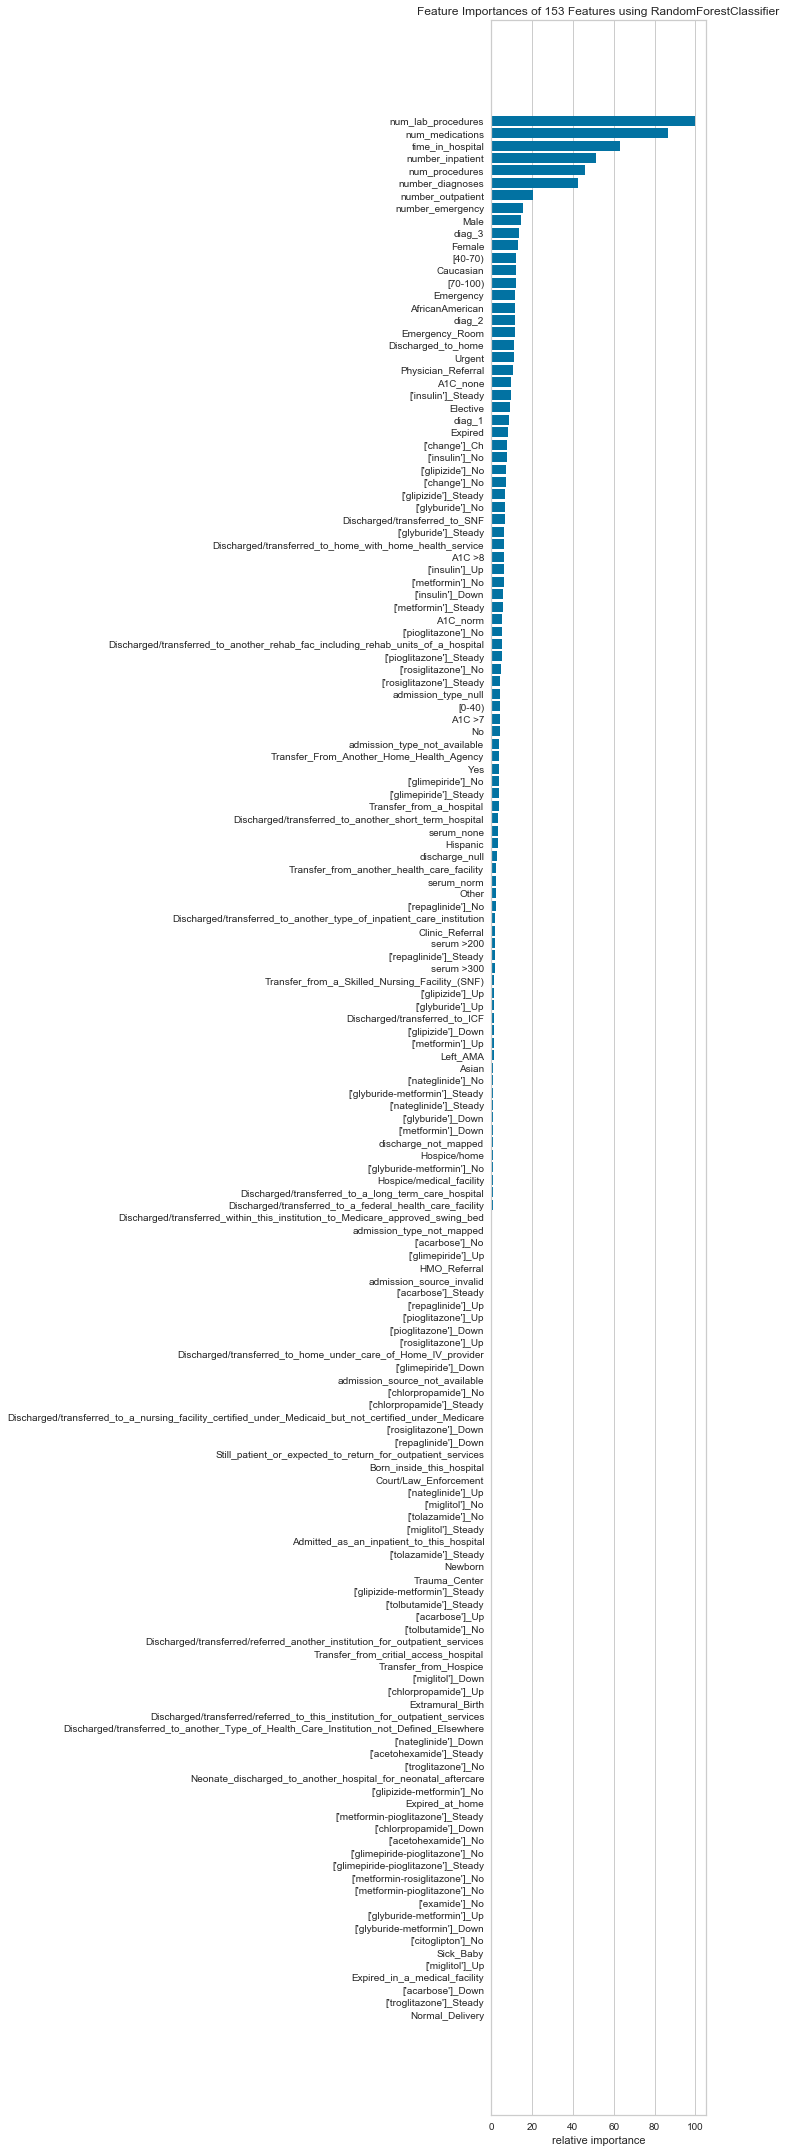

In [23]:
from yellowbrick.features.importances import FeatureImportances
fig = plt.figure(figsize = (10,30))
ax = fig.add_subplot()

viz = FeatureImportances(clf, ax=ax)
viz.fit(x, y)
viz.poof()

In [24]:
np.sort(clf.feature_importances_)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.36768566e-07,
       1.72537950e-06, 2.50226592e-06, 3.02224913e-06, 3.72978975e-06,
       4.18356966e-06, 4.23408607e-06, 4.38011017e-06, 5.26080093e-06,
       7.18914553e-06, 7.60537709e-06, 8.03210717e-06, 1.05033600e-05,
       1.14757189e-05, 1.32668731e-05, 1.43943731e-05, 1.68754268e-05,
       1.75043822e-05, 1.79467212e-05, 1.88242537e-05, 1.92181122e-05,
       3.53796108e-05, 4.23931702e-05, 4.37735835e-05, 4.49639570e-05,
       4.50739058e-05, 4.68400964e-05, 4.92936070e-05, 5.04774095e-05,
       6.21746368e-05, 8.77992219e-05, 9.09616930e-05, 9.44761261e-05,
       1.21341748e-04, 1.44561856e-04, 1.54449056e-04, 1.84690349e-04,
       2.63547229e-04, 3.18345572e-04, 3.40751024e-04, 3.41586655e-04,
      

In [25]:
x_rfe = rfecv.transform(x)

In [26]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

In [27]:
def classifier_metrics(estimator,y_pred):
    class_metrics = {'Accuracy' : metrics.accuracy_score(y, y_pred),
                     'Precision' : metrics.precision_score(y, y_pred),
                     'Recall' : metrics.recall_score(y, y_pred),
                     'F1 Score' : metrics.f1_score(y, y_pred)
                    }


    df_metrics = pd.DataFrame.from_dict(class_metrics, orient='index')
    print('\nConfusion Matrix:')
    skplt.metrics.plot_confusion_matrix(y, y_pred)
    
    print('\nClassification Report:')
    print(metrics.classification_report(y,y_pred,digits=2))
    
    print('\nMetrics:')
    print(df_metrics)
    
    return  df_metrics

In [28]:
def plot_roc(model,x_test,y):
    model_proba = cross_val_predict(model, x_test, y, cv=3, n_jobs=-1, verbose=1, method = 'predict_proba')
    fig = plt.figure()
    ax1 = fig.add_subplot()
    skplt.metrics.plot_roc(y,model_proba ,figsize = (15,7),title_fontsize='large',text_fontsize='large')                
    return None

In [29]:
def precision_recall(model,x_test,y):
    model_proba = cross_val_predict(model, x_test, y, cv=3, n_jobs=-1, verbose=1, method = 'predict_proba')
    fig = plt.figure()
    ax1 = fig.add_subplot()
    skplt.metrics.plot_precision_recall(y,model_proba,figsize = (15,7),title_fontsize='large',text_fontsize='large')                 
    return None

### Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(solver = 'saga', random_state = 100, class_weight = {0:1,1:9}, penalty = 'l1', n_jobs = -1)
param_grid = {'C':[0.1,1,5]}
grid_search1= GridSearchCV(log,param_grid, cv=3, scoring = 'accuracy', n_jobs=-1, verbose = 2)
grid_search1.fit(x_rfe,y)

print("Best Parameters : {}".format(grid_search1.best_params_))
print("Best cross_val score : {}".format(grid_search1.best_score_))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   16.9s remaining:   21.2s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   22.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   22.2s finished


Best Parameters : {'C': 1}
Best cross_val score : 0.5658828777161792


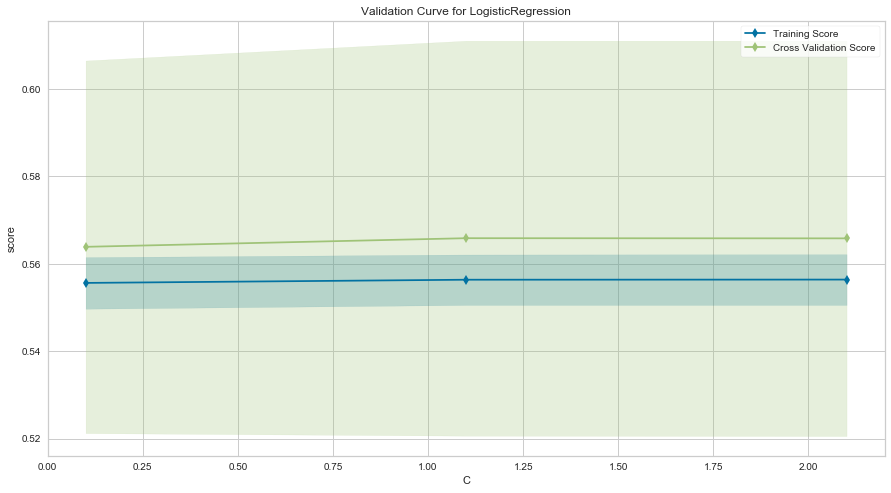

In [32]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
viz = ValidationCurve(log, ax=ax, param_name="C", param_range=np.arange(0.1,3.1,1), cv=3, scoring="accuracy")
viz.fit(x_rfe, y)
viz.poof()

In [33]:
logreg = LogisticRegression(solver = 'saga', random_state = 100, class_weight = {0:1,1:9}, penalty = 'l1', n_jobs = -1, C=1)
logreg.fit(x_rfe,y)
log_pred = cross_val_predict(logreg, x_rfe, y, cv=3, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.0s finished



Confusion Matrix:

Classification Report:
             precision    recall  f1-score   support

          0       0.92      0.56      0.69     69617
          1       0.16      0.64      0.25      8848

avg / total       0.84      0.57      0.64     78465


Metrics:
                  0
Accuracy   0.565883
Precision  0.155730
Recall     0.644552
F1 Score   0.250852


,0
Accuracy,0.565883
Precision,0.155730
Recall,0.644552
F1 Score,0.250852


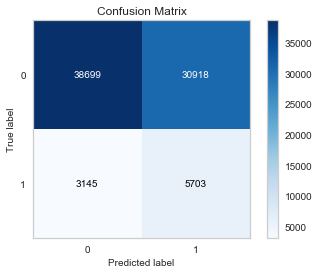

In [34]:
classifier_metrics(logreg,log_pred)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.0s finished


<Figure size 432x288 with 0 Axes>

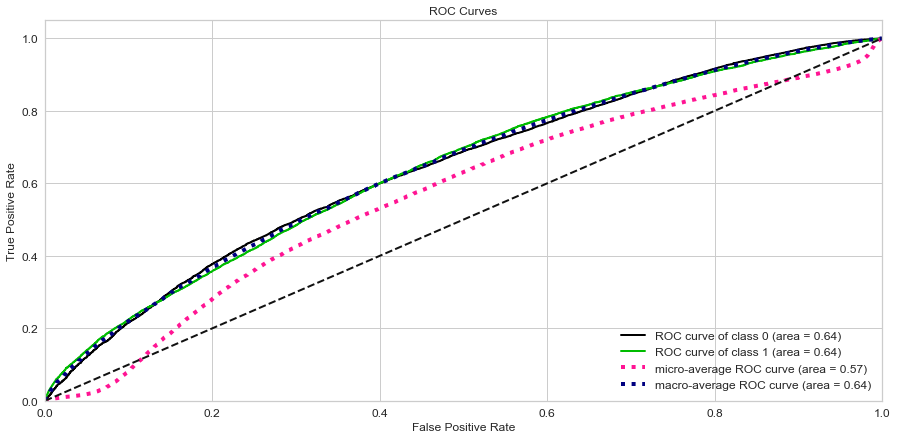

In [35]:
plot_roc(logreg,x_rfe,y)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.0s finished


<Figure size 432x288 with 0 Axes>

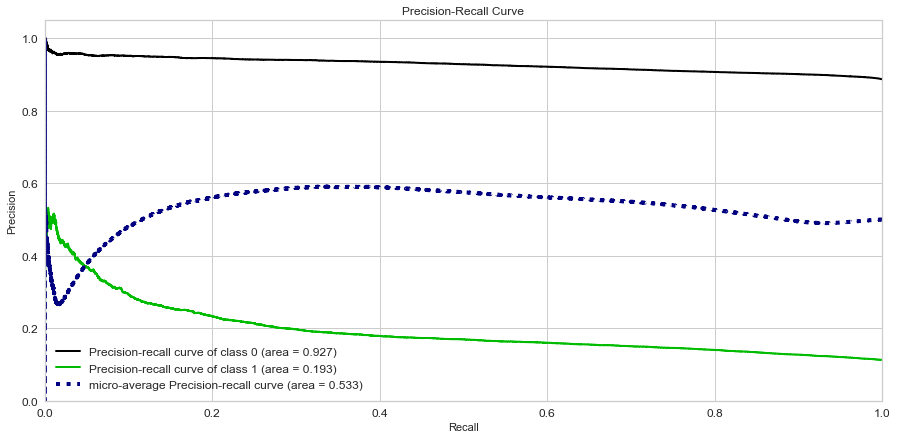

In [36]:
precision_recall(logreg,x_rfe,y)

### Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier
ranf = RandomForestClassifier(random_state=100, oob_score=True, n_jobs=-1, class_weight = {0:1,1:9}, min_samples_leaf = 100)
param_grid = {'n_estimators':[150,200,250]}
grid_search3= GridSearchCV(ranf,param_grid, cv=3, scoring = 'accuracy', n_jobs=-1, verbose=2)
grid_search3.fit(x_rfe,y)

print("Best Parameters : {}".format(grid_search3.best_params_))
print("Best cross_val score : {}".format(grid_search3.best_score_))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   21.2s remaining:   26.5s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   39.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   39.0s finished


Best Parameters : {'n_estimators': 200}
Best cross_val score : 0.5570636589562226


In [40]:
ranfor = RandomForestClassifier(random_state=100, oob_score=True, n_jobs=-1, class_weight = {0:1,1:9}, n_estimators=200,
                               min_samples_leaf = 100)
ranfor.fit(x_rfe,y)
ranfor_pred = cross_val_predict(ranfor, x_rfe, y, cv=3, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.8s finished



Confusion Matrix:

Classification Report:
             precision    recall  f1-score   support

          0       0.93      0.54      0.69     69617
          1       0.16      0.66      0.25      8848

avg / total       0.84      0.56      0.64     78465


Metrics:
                  0
Accuracy   0.557064
Precision  0.155189
Recall     0.658906
F1 Score   0.251212


,0
Accuracy,0.557064
Precision,0.155189
Recall,0.658906
F1 Score,0.251212


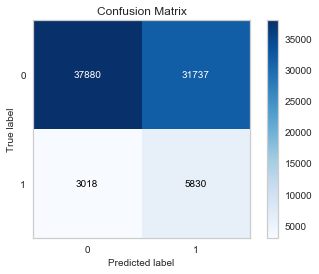

In [41]:
classifier_metrics(ranfor,ranfor_pred)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.7s finished


<Figure size 432x288 with 0 Axes>

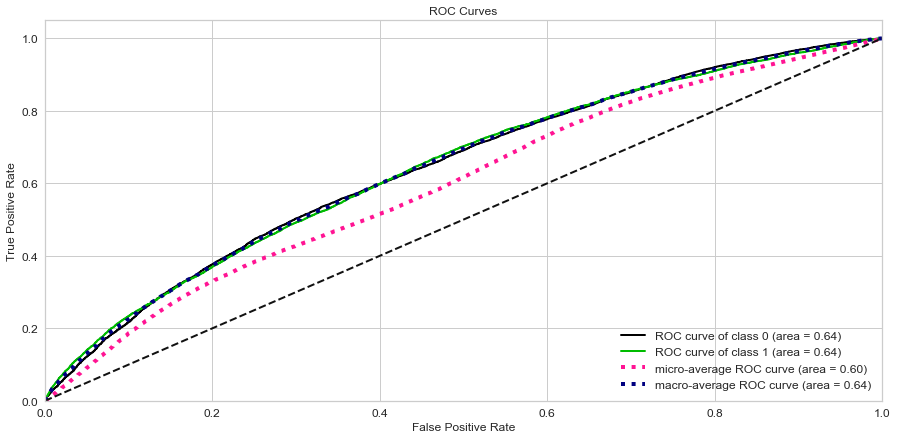

In [42]:
plot_roc(ranfor,x_rfe,y)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.9s finished


<Figure size 432x288 with 0 Axes>

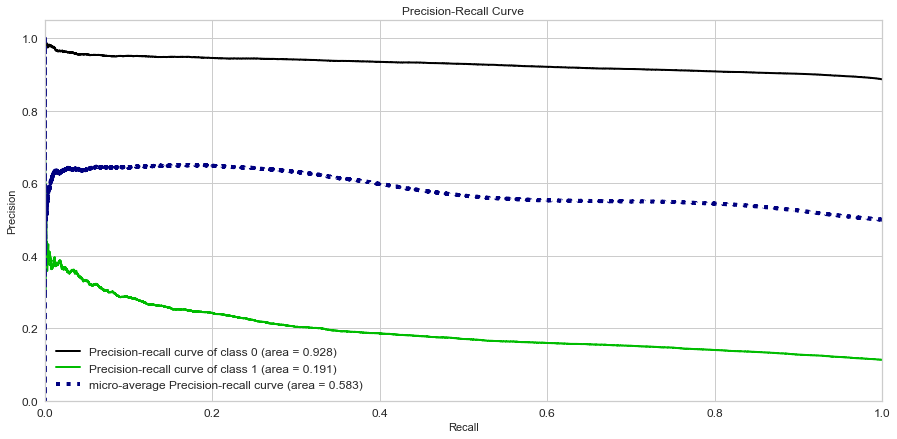

In [43]:
precision_recall(ranfor,x_rfe,y)

### Boosting can improve model performance

In [44]:
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier(ranfor, random_state = 10)
adaboost.fit(x_rfe, y)
adaboost_pred = cross_val_predict(adaboost, x_rfe, y, cv=3, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 12.1min finished



Confusion Matrix:

Classification Report:
             precision    recall  f1-score   support

          0       0.90      0.85      0.87     69617
          1       0.18      0.26      0.21      8848

avg / total       0.82      0.78      0.80     78465


Metrics:
                  0
Accuracy   0.783929
Precision  0.180766
Recall     0.259381
F1 Score   0.213052


,0
Accuracy,0.783929
Precision,0.180766
Recall,0.259381
F1 Score,0.213052


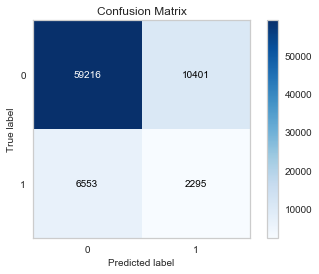

In [45]:
classifier_metrics(adaboost,adaboost_pred)

### Importing test data set

In [94]:
test = pd.read_csv('test_data.csv', na_values=['?'])
test.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
0,15738,63555939,Caucasian,Female,[90-100),NaN,3,3,4,12,...,No,No,Steady,No,No,No,No,No,Ch,Yes
1,62256,49726791,AfricanAmerican,Female,[60-70),NaN,3,1,2,1,...,No,No,Steady,No,No,No,No,No,No,Yes
2,150006,22864131,NaN,Female,[50-60),NaN,2,1,4,2,...,No,No,Down,No,No,No,No,No,Ch,Yes
3,183930,107400762,Caucasian,Female,[80-90),NaN,2,6,1,11,...,No,No,No,No,No,No,No,No,No,No
4,248916,115196778,Caucasian,Female,[50-60),NaN,1,1,1,2,...,No,No,Steady,No,No,No,No,No,No,Yes


In [47]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20352 entries, 0 to 20351
Data columns (total 49 columns):
encounter_id                20352 non-null int64
patient_nbr                 20352 non-null int64
race                        19892 non-null object
gender                      20352 non-null object
age                         20352 non-null object
weight                      627 non-null object
admission_type_id           20352 non-null int64
discharge_disposition_id    20352 non-null int64
admission_source_id         20352 non-null int64
time_in_hospital            20352 non-null int64
payer_code                  12327 non-null object
medical_specialty           10338 non-null object
num_lab_procedures          20352 non-null int64
num_procedures              20352 non-null int64
num_medications             20352 non-null int64
number_outpatient           20352 non-null int64
number_emergency            20352 non-null int64
number_inpatient            20352 non-null int64
diag_

In [95]:
percentage_missing_test = (test.isnull().sum()*100)/(len(test))
print(percentage_missing_test)

encounter_id                 0.000000
patient_nbr                  0.000000
race                         2.260220
gender                       0.000000
age                          0.000000
weight                      96.919222
admission_type_id            0.000000
discharge_disposition_id     0.000000
admission_source_id          0.000000
time_in_hospital             0.000000
payer_code                  39.431014
medical_specialty           49.204009
num_lab_procedures           0.000000
num_procedures               0.000000
num_medications              0.000000
number_outpatient            0.000000
number_emergency             0.000000
number_inpatient             0.000000
diag_1                       0.014741
diag_2                       0.343947
diag_3                       1.464230
number_diagnoses             0.000000
max_glu_serum                0.000000
A1Cresult                    0.000000
metformin                    0.000000
repaglinide                  0.000000
nateglinide 

In [96]:
test.drop(['weight','payer_code','medical_specialty','encounter_id','patient_nbr'], axis=1, inplace=True)

In [97]:
test.dropna(subset = ["race","diag_1","diag_2","diag_3"], inplace=True)
test = test[test["gender"] != "Unknown/Invalid"]
test.reset_index(drop=True, inplace=True)

In [51]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19587 entries, 0 to 19586
Data columns (total 44 columns):
race                        19587 non-null object
gender                      19587 non-null object
age                         19587 non-null object
admission_type_id           19587 non-null int64
discharge_disposition_id    19587 non-null int64
admission_source_id         19587 non-null int64
time_in_hospital            19587 non-null int64
num_lab_procedures          19587 non-null int64
num_procedures              19587 non-null int64
num_medications             19587 non-null int64
number_outpatient           19587 non-null int64
number_emergency            19587 non-null int64
number_inpatient            19587 non-null int64
diag_1                      19587 non-null object
diag_2                      19587 non-null object
diag_3                      19587 non-null object
number_diagnoses            19587 non-null int64
max_glu_serum               19587 non-null object
A1

In [98]:
test['diag_1'] = test['diag_1'].astype(str)
test['diag_2'] = test['diag_2'].astype(str)
test['diag_3'] = test['diag_3'].astype(str)
test['diag_1'] = [1 if val.startswith('250') else 0 for val in test['diag_1']]
test['diag_2'] = [1 if val.startswith('250') else 0 for val in test['diag_2']]
test['diag_3'] = [1 if val.startswith('250') else 0 for val in test['diag_3']]

In [99]:
test['age'] = ['[0-40)' if val in ['[0-10)', '[10-20)', '[20-30)', '[30-40)'] else ('[40-70)' if val in ['[40-50)',  '[50-60)', '[60-70)'] 
               else '[70-100)') for val in test['age']]

In [100]:
test.discharge_disposition_id.replace(list(range(1,len(discharge_types)+1)),discharge_types, inplace=True)
test.discharge_disposition_id.head()

0                        Discharged/transferred_to_SNF
1                                   Discharged_to_home
2    Discharged/transferred_to_home_with_home_healt...
3                                   Discharged_to_home
4                                   Discharged_to_home
Name: discharge_disposition_id, dtype: object

In [101]:
test.admission_source_id.replace(list(range(1,len(admission_sources)+1)),admission_sources, inplace=True)
test.admission_source_id.head()

0    Transfer_from_a_hospital
1             Clinic_Referral
2          Physician_Referral
3          Physician_Referral
4              Emergency_Room
Name: admission_source_id, dtype: object

In [102]:
test.admission_type_id.replace(list(range(1,len(admission_types)+1)),admission_types, inplace=True)
test.admission_type_id.head()

0     Elective
1     Elective
2       Urgent
3    Emergency
4    Emergency
Name: admission_type_id, dtype: object

In [103]:
test['max_glu_serum'] = ['serum_none' if val == 'None' else ('serum >200' if val == '>200' else 'serum >300' if val == '>300'
                       else 'serum_norm') for val in test['max_glu_serum']]

In [104]:
test['A1Cresult'] = ['A1C_none' if val == 'None' else ('A1C >7' if val == '>7' else 'A1C >8' if val == '>8'
                       else 'A1C_norm') for val in test['A1Cresult']]

In [105]:
test['discharge_disposition_id'] = test['discharge_disposition_id'].replace({'NULL':'discharge_null',
                                                                             'Not_Mapped':'discharge_not_mapped',
                                                                            'Unknown/Invalid':'discharge_invalid'})
test['admission_source_id'] = test['admission_source_id'].replace({'NULL':'admission_source_null',
                                                                             'Not_Mapped':'admission_source_not_mapped',
                                                                            'Unknown/Invalid':'admission_source_invalid',
                                                                  'Not_Available':'admission_source_not_available'})
test['admission_type_id'] = test['admission_type_id'].replace({'NULL':'admission_type_null',
                                                                             'Not_Mapped':'admission_type_not_mapped',
                                                                            'Not_Available':'admission_type_not_available'})

In [106]:
test_age = pd.get_dummies(test['age'])
test_race = pd.get_dummies(test['race'])
test_gender = pd.get_dummies(test['gender'])
test_max_glu_serum = pd.get_dummies(test['max_glu_serum'])
test_A1Cresult = pd.get_dummies(test['A1Cresult'])
test_dischange = pd.get_dummies(test['discharge_disposition_id'])
test_admission_source = pd.get_dummies(test['admission_source_id'])
test_admission_type = pd.get_dummies(test['admission_type_id'])
test_diabetesMed = pd.get_dummies(test['diabetesMed'])

In [107]:
test_insulin = pd.get_dummies(test['insulin'], prefix = 'insulin')
test_metformin = pd.get_dummies(test['metformin'], prefix = 'metformin')
test_repaglinide = pd.get_dummies(test['repaglinide'], prefix = 'repaglinide')
test_nateglinide = pd.get_dummies(test['nateglinide'], prefix = 'nateglinide')
test_chlorpropamide = pd.get_dummies(test['chlorpropamide'], prefix = 'chlorpropamide')
test_glimepiride = pd.get_dummies(test['glimepiride'], prefix = 'glimepiride')
test_acetohexamide = pd.get_dummies(test['acetohexamide'], prefix = 'acetohexamide')
test_glipizide = pd.get_dummies(test['glipizide'], prefix = 'glipizide')
test_glyburide = pd.get_dummies(test['glyburide'], prefix = 'glyburide')
test_tolbutamide = pd.get_dummies(test['tolbutamide'], prefix = 'tolbutamide')
test_pioglitazone = pd.get_dummies(test['pioglitazone'], prefix = 'pioglitazone')
test_rosiglitazone = pd.get_dummies(test['rosiglitazone'], prefix = 'rosiglitazone')
test_acarbose = pd.get_dummies(test['acarbose'], prefix = 'acarbose')
test_miglitol = pd.get_dummies(test['miglitol'], prefix = 'miglitol')
test_troglitazone = pd.get_dummies(test['troglitazone'], prefix = 'troglitazone')
test_tolazamide = pd.get_dummies(test['tolazamide'], prefix = 'tolazamide')
test_examide = pd.get_dummies(test['examide'], prefix = 'examide')
test_citoglipton = pd.get_dummies(test['citoglipton'], prefix = 'citoglipton')
test_glyburide_metformin = pd.get_dummies(test['glyburide-metformin'], prefix = 'glyburide-metformin')
test_glipizide_metformin = pd.get_dummies(test['glipizide-metformin'], prefix = 'glipizide-metformin')
test_glimepiride_pioglitazone = pd.get_dummies(test['glimepiride-pioglitazone'], prefix = 'glimepiride-pioglitazone')
test_metformin_rosiglitazone = pd.get_dummies(test['metformin-rosiglitazone'], prefix = 'metformin-rosiglitazone')
test_metformin_pioglitazone = pd.get_dummies(test['metformin-pioglitazone'], prefix = 'metformin-pioglitazone')
test_change = pd.get_dummies(test['change'], prefix = 'change')

In [108]:
test = pd.concat([test, test_age, test_race, test_gender, test_max_glu_serum, test_A1Cresult, test_dischange, test_admission_source,
                  test_admission_type, test_diabetesMed, test_insulin, test_metformin, test_repaglinide, test_nateglinide,
                 test_chlorpropamide, test_glimepiride, test_acetohexamide, test_glipizide, test_glyburide, test_tolbutamide,
                 test_pioglitazone, test_rosiglitazone, test_acarbose, test_miglitol, test_troglitazone, test_tolazamide,
                 test_examide, test_citoglipton, test_glyburide_metformin, test_glipizide_metformin, test_glimepiride_pioglitazone,
                 test_metformin_rosiglitazone, test_metformin_pioglitazone, test_change], axis=1)
test.drop(['race','gender','age','admission_type_id','discharge_disposition_id','admission_source_id','max_glu_serum',
           'A1Cresult','metformin','repaglinide','nateglinide','insulin',
           'chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone',
           'acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton','insulin','glyburide-metformin',
           'glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone','change',
           'diabetesMed'], axis=1, inplace=True)

In [109]:
test.astype('int64')

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,...,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,glipizide-metformin_No,glipizide-metformin_Steady,glimepiride-pioglitazone_No,metformin-rosiglitazone_No,metformin-pioglitazone_No,change_Ch,change_No
0,12,33,3,18,0,0,0,0,0,0,...,0,1,0,1,0,1,1,1,1,0
1,1,49,5,2,0,0,0,0,0,0,...,0,1,0,1,0,1,1,1,0,1
2,11,42,2,19,0,0,0,0,0,0,...,0,1,0,1,0,1,1,1,0,1
3,2,25,2,11,0,0,0,0,0,1,...,0,1,0,1,0,1,1,1,0,1
4,6,27,0,16,0,0,0,0,0,1,...,0,1,0,1,0,1,1,1,0,1
5,3,33,1,8,0,0,0,0,0,1,...,0,1,0,1,0,1,1,1,0,1
6,13,48,2,18,0,0,1,0,0,0,...,0,1,0,1,0,1,1,1,1,0
7,3,59,0,11,0,0,0,0,0,0,...,0,1,0,1,0,1,1,1,1,0
8,6,65,5,19,0,0,0,0,0,0,...,0,1,0,1,0,1,1,1,1,0
9,11,67,2,25,0,0,0,0,0,0,...,0,1,0,1,0,1,1,1,1,0


In [110]:
test.to_csv('test_final.csv')

In [111]:
test1 = test[['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_2', 'diag_3', 'number_diagnoses', '[40-70)',
       'AfricanAmerican', 'Caucasian', 'Female', 'Male', 'A1C_none',
       'Discharged_to_home', 'Emergency_Room', 'Physician_Referral',
       'Emergency', 'Urgent', 'insulin_Steady', 'metformin_No',
       'glipizide_No', 'glyburide_No', 'pioglitazone_No',
       'change_No']]

### Predictions

In [112]:
y_pred_test = ranfor.predict(test1)
y_pred_df = pd.DataFrame(y_pred_test)
y_pred_df.to_csv('output.csv')

In [113]:
y_pred_test

array([1, 0, 0, ..., 0, 0, 1], dtype=int64)

In [3]:
final = pd.read_csv('C:/Users/adity/Downloads/ML/test_data_predictions.csv')

In [4]:
final_readmitted = final[final["Predictions"] == 1]

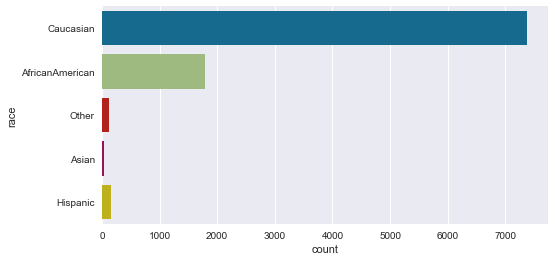

In [91]:
sn.set_style('darkgrid')
fig=plt.figure(figsize=(8,4))
ax=sn.countplot(y="race",data=final_readmitted)

plt.show()

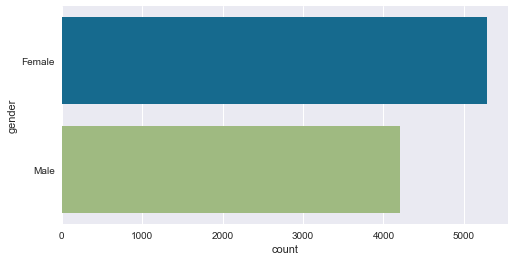

In [92]:
sn.set_style('darkgrid')
fig=plt.figure(figsize=(8,4))
ax=sn.countplot(y="gender",data=final_readmitted)

plt.show()

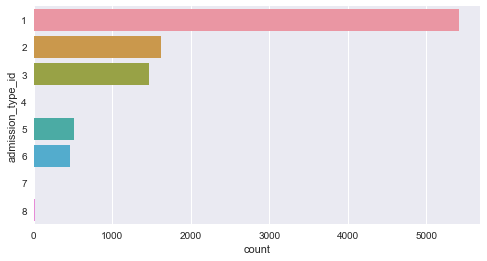

In [8]:
sn.set_style('darkgrid')
fig=plt.figure(figsize=(8,4))
ax=sn.countplot(y="admission_type_id",data=final_readmitted)

plt.show()

### Conclusion

### •	Readmission rate of Caucasians is 3 times more than all other races combined and males are 3% more likely to be readmitted than females.
### •	Age group 70-100 has a 20% higher chance of diabetes readmission than other age groups and emergency admissions have 30% higher chance of readmission than all other admission types combined.

### References

#### https://www.hindawi.com/journals/bmri/2014/781670/
#### https://www.kaggle.com/c/diabetes-hospital-readmission/data